# 07. 범주형 데이터 이진 분류
* 대회명
    * [Categorical Feature Encoding Challenge](https://www.kaggle.com/c/cat-in-the-dat)
        * Binary classification, with every feature a categorical
* 미션 : 다양한 범주형 데이터를 활용해 1에 속할 확률 예측
* 문제 유형 : 이진 분류
* 평가지표 : ROC AUC
* 사용한 모델 : 로지스틱 회귀
* 탐색적 데이터 분석
    * 피처 요약표
    * 타깃값 분포
    * 이진/명목형/순서형/날짜 피처 분포
* 피처 엔지니어링
    * 원핫 인코딩
    * 피처 맞춤 인코딩
    * 피처 스케일링
* 하이퍼 파라미터 최적화 : 그리드서치
## 7.1 경진대회 이해
* 특이점
    * 인위적으로 만든 데이터 제공
    * 각 피처와 타깃값의 의미를 알 수 없음
    * 제공되는 데이터는 모두 범주형 데이터
        * 이진 피처 : bin_로 시작
        * 명목형 피처 : nom_로 시작
        * 순서형 피처 : ord_로 시작
        * 타깃값 : 0,1로 구성
* 참고 코드
    * https://www.kaggle.com/kabure/eda-feat-engineering-encode-conquer
## 7.2 탐색적 데이터 분석
### 7.2.1 데이터 둘러보기
### 7.2.2 데이터 시각화

### 7.2.1 데이터 둘러보기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = '../../data/07_categorical/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test = pd.read_csv(data_path+'test.csv', index_col='id')
submission = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

In [3]:
train.shape, test.shape

((300000, 24), (200000, 23))

In [4]:
train.head().T

id,0,1,2,3,4
bin_0,0,0,0,0,0
bin_1,0,1,0,1,0
bin_2,0,0,0,0,0
bin_3,T,T,F,F,F
bin_4,Y,Y,Y,Y,N
nom_0,Green,Green,Blue,Red,Red
nom_1,Triangle,Trapezoid,Trapezoid,Trapezoid,Trapezoid
nom_2,Snake,Hamster,Lion,Snake,Lion
nom_3,Finland,Russia,Russia,Canada,Canada
nom_4,Bassoon,Piano,Theremin,Oboe,Oboe


In [5]:
submission.head()

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


In [6]:
# feature summary
def resume_table(df):
    print(f'shape : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'feature'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고유값 개수'] = df.nunique().values
    summary['1th value'] = df.loc[0].values
    summary['2th value'] = df.loc[1].values
    summary['3th value'] = df.loc[2].values

    return summary

resume_table(train)

shape : (300000, 24)


,feature,type,결측값 개수,고유값 개수,1th value,2th value,3th value
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


In [7]:
# 동작 확인 코드
type(train.dtypes)

pandas.core.series.Series

In [8]:
# 동작 확인 코드
train.isnull().sum(axis=0)

bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

In [9]:
# 동작 확인 코드
summary = pd.DataFrame(train.dtypes, columns=['type'])
summary = summary.reset_index()
summary['결측값 개수'] = train.isnull().sum()
summary

,index,type,결측값 개수
0,bin_0,int64,NaN
1,bin_1,int64,NaN
2,bin_2,int64,NaN
3,bin_3,object,NaN
4,bin_4,object,NaN
5,nom_0,object,NaN
6,nom_1,object,NaN
7,nom_2,object,NaN
8,nom_3,object,NaN
9,nom_4,object,NaN


* 이진 피처
    * bin_0~bin_4
    * T와 Y는 1로, F와 N은 0으로 인코딩
* 명목형 피처
    * nom_0~nom_9
    * 원핫 인코딩
* 순서형 피처
    * ord_0~ord_5
    * 순서에 따라 타깃값에 미치는 영향이 다름
    * ord_1 : 'Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster' 순 정렬
    * ord_2 : 'Freezing', 'Cold', 'Warm', 'Hot', 'Bolling Hot', 'Lava Hot' 순 정렬
    * CategoricalDtype()을 활용
* 그 외 피처
    * day, month, target

In [10]:
# 순서형 피처 확인
for i in range(6):
    feature = f'ord_{i}'
    print(f'{feature} 고유값 : {train[feature].unique()}')

ord_0 고유값 : [2 1 3]
ord_1 고유값 : ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고유값 : ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']
ord_3 고유값 : ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고유값 : ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고유값 : ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'N

In [11]:
# day, month, target 피처 확인
for f in ['day', 'month', 'target']:
    print(f'{f} 고유값 : {train[f].unique()}')

day 고유값 : [2 7 5 4 3 1 6]
month 고유값 : [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 고유값 : [0 1]


### 7.2.2 데이터 시각화
* 수치형 데이터의 분포를 파악할 땐 displot() 사용
* 범주형 데이터의 분포를 파악할 땐 countplot() 사용

Text(0.5, 1.0, 'Target Distribution')

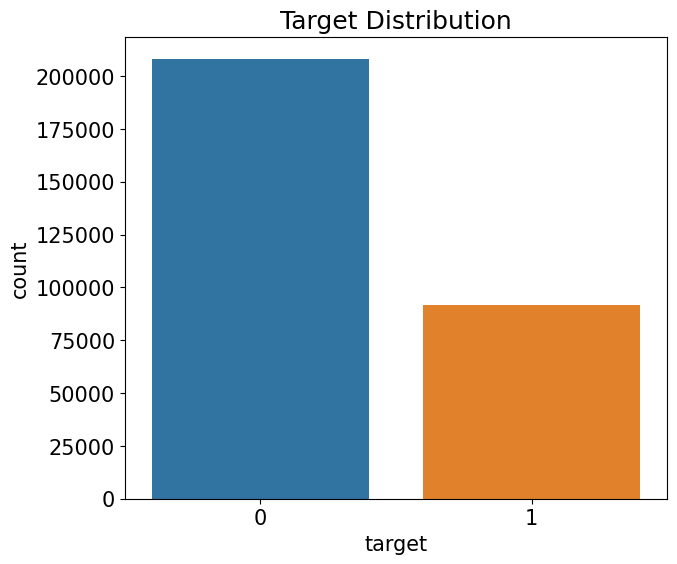

In [12]:
# 타깃값 분포
import matplotlib as mpl
mpl.rc('font', size=15)
plt.figure(figsize=(7,6))

# 타깃값 분포 카운트 플롯
ax = sns.countplot(data=train, x='target')
ax.set_title('Target Distribution')

# `ax.patches`
* ax축을 구성하는 그래프 도형 객체 모두를 담은 리스트

In [13]:
print(ax.patches)

<Axes.ArtistList of 2 patches>


In [14]:
rectangle = ax.patches[0]
print(f'사격형 높이: {rectangle.get_height()}') # 데이터 개수와 같음
print(f'사격형 넓이: {rectangle.get_width()}')
print(f'사각형 왼쪽 테두리의 x축 위치 : {rectangle.get_x()}')

사격형 높이: 208236.0
사격형 넓이: 0.8
사각형 왼쪽 테두리의 x축 위치 : -0.4


In [15]:
print(f'텍스트 위치의 x좌표 : {rectangle.get_x() + rectangle.get_width() / 2.0}')
print(f'텍스트 위치의 y좌표 : {rectangle.get_height() + len(train) * 0.001}')

텍스트 위치의 x좌표 : 0.0
텍스트 위치의 y좌표 : 208536.0


Text(0.5, 1.0, 'Target Distribution')

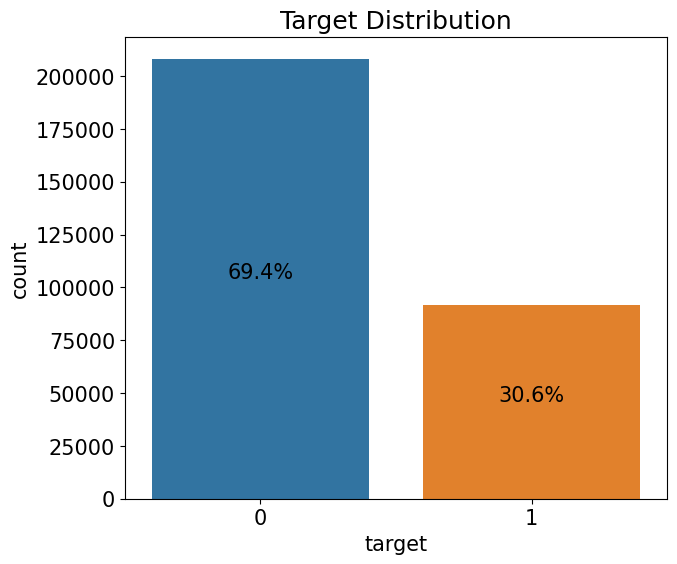

In [16]:
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100

        ax.text(
            x=left_coord + width/2.0,
            y=height/2.0,
            s=f'{percent:.1f}%',
            ha='center'
        )
plt.figure(figsize=(7,6))

ax = sns.countplot(data=train, x='target')
write_percent(ax, len(train))
ax.set_title('Target Distribution')

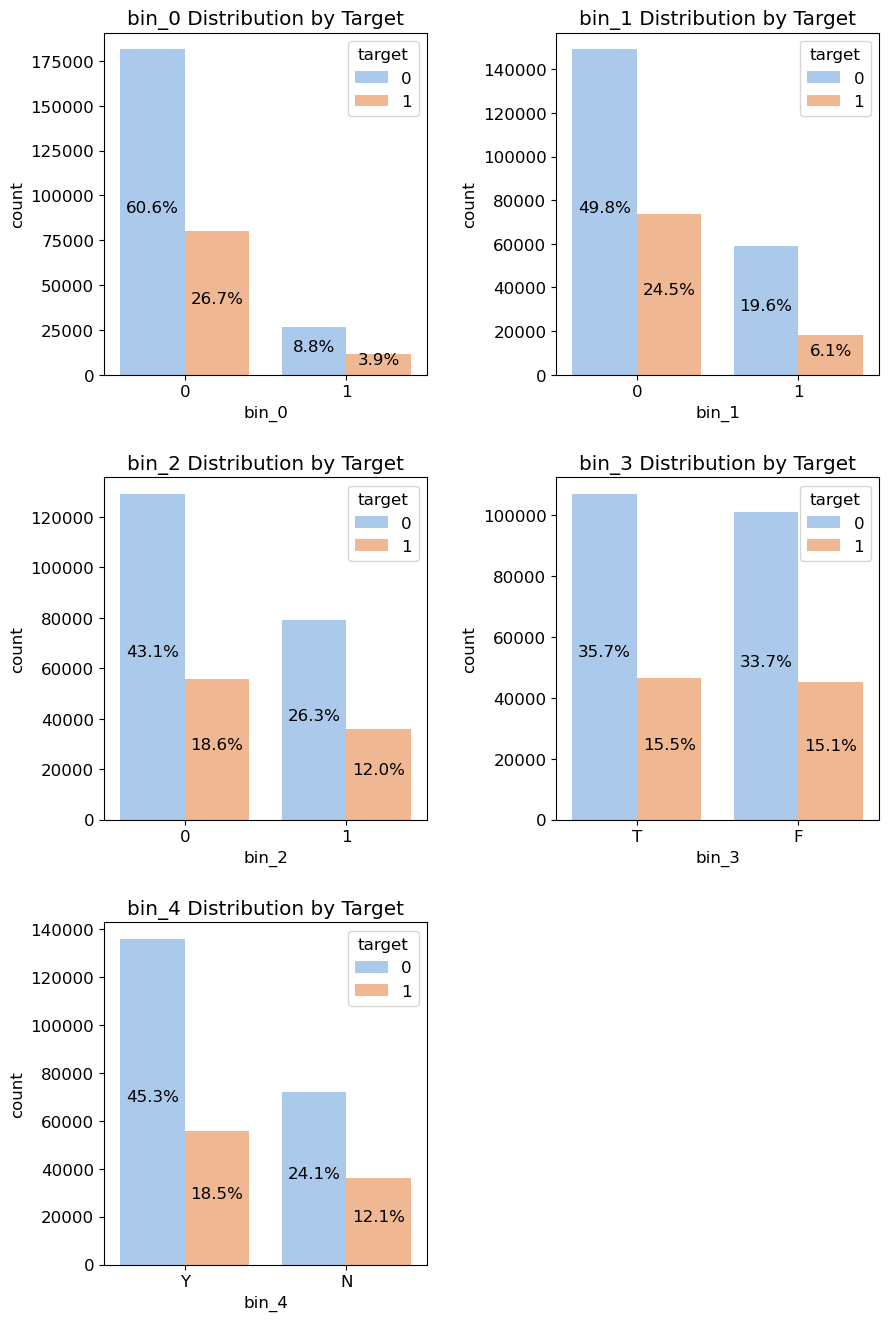

In [17]:
# 이진 피처 분포
import matplotlib.gridspec as gridspec
mpl.rc('font', size=12)
grid = gridspec.GridSpec(3,2)
plt.figure(figsize=(10, 16))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

for idx, feature in enumerate(bin_features):
    ax = plt.subplot(grid[idx])
    sns.countplot(data=train, x=feature, hue='target', palette='pastel', ax=ax)
    ax.set_title(f'{feature} Distribution by Target')
    write_percent(ax, len(train))

#### 명목형 피처 분포
* 검토 과정
    * 피처별 고유값 비율 확인
    * 피처별 고유값 중 타깃값이 1인 비율 확인
* 확인 방법
    * 교차분석표 생성 함수 만들기
        * 범주형 데이터 2개를 비교 분석하는 데 사용되는 표
        * 각 범주형 데이터의 빈도나 통계량을 행과 열로 결합놓은 표
        * 피처별 타깃값 1인 비율을 구하기 위하여 교차분석표를 만듬
        * 판다스의 corsstab() 함수 활용
    * 포인트플롯 생성 함수 만들기
    * 피처 분포도 및 포인트플롯 생성 함수 만들기
* 분석 결과
    * 명목형 피처는 모두 원핫 인코딩

In [18]:
# 교차분석표 생성 함수 만들기
cross_tab = pd.crosstab(train['nom_0'], train['target'], normalize='index')* 100
cross_tab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [19]:
def get_crosstab(df, feature):
    cross_tab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    cross_tab = cross_tab.reset_index()
    return cross_tab

cross_tab = get_crosstab(train, 'nom_0')
cross_tab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


In [20]:
# 포인트플롯 생성 함수 만들기
def plot_pointplot(ax, feature, cross_tab):
    ax2 = ax.twinx()
    sns.pointplot(data=cross_tab, x=feature, y=1, order=cross_tab[feature].values, color='black', ax=ax2)
    ax2.set_ylim(cross_tab[1].min()-5, cross_tab[1].max()*1.1)
    ax2.set_ylabel('Target 1 Ratio(%)')

In [21]:
# 피처 분포도 및 피처별 타깃값 1의 비율 포인트플롯 생성 함수 만들기
def plot_cat_dist_true_ratio(df, features, num_rows, num_cols, size=(15, 20)):
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols)
    plt.subplots_adjust(wspace=0.45, hspace=0.3)

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        cross_tab = get_crosstab(df, feature)
        sns.countplot(data=df, x=feature, order=cross_tab[feature].values, color='skyblue', ax=ax)
        write_percent(ax, len(df))
        plot_pointplot(ax, feature, cross_tab)
        ax.set_title(f'{feature} Distribution')

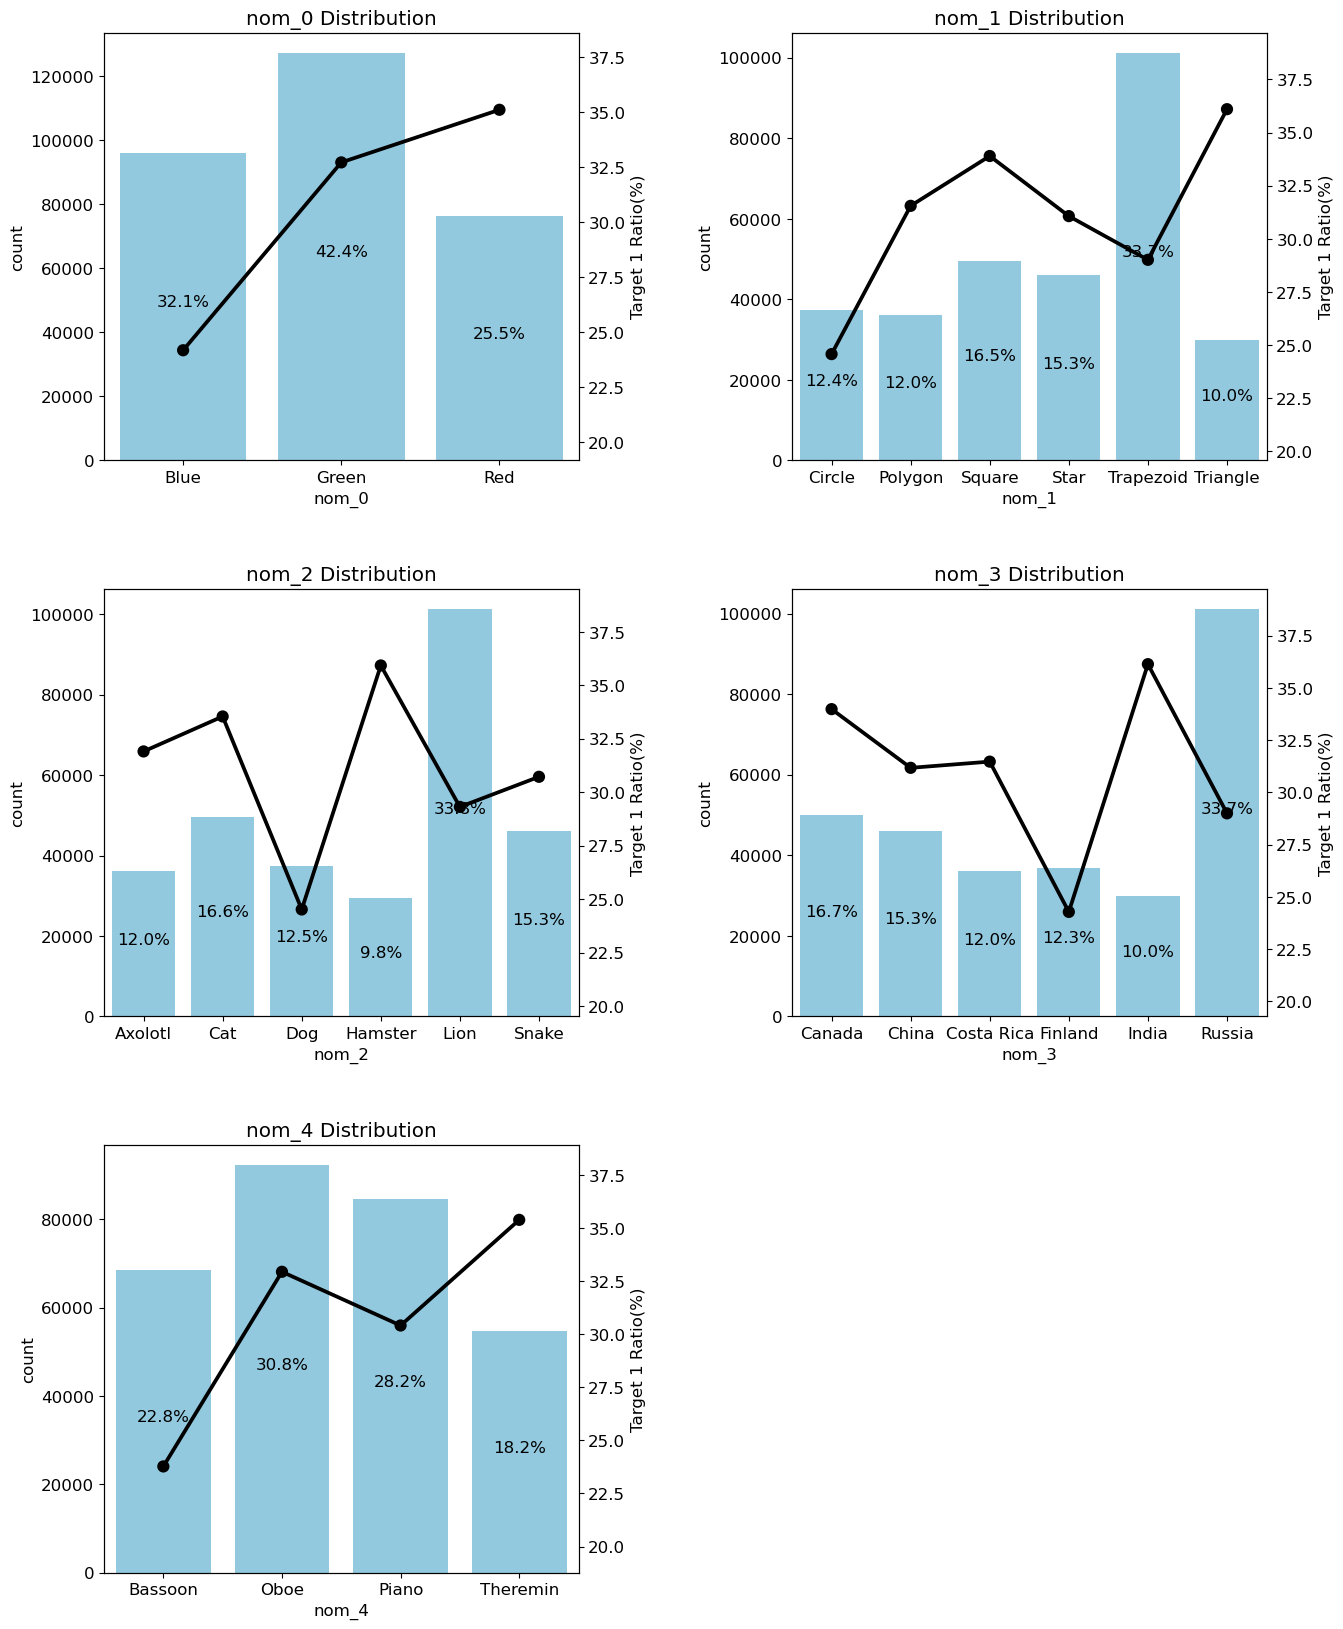

In [22]:
nom_feature = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
plot_cat_dist_true_ratio(train, nom_feature, num_rows=3, num_cols=2)

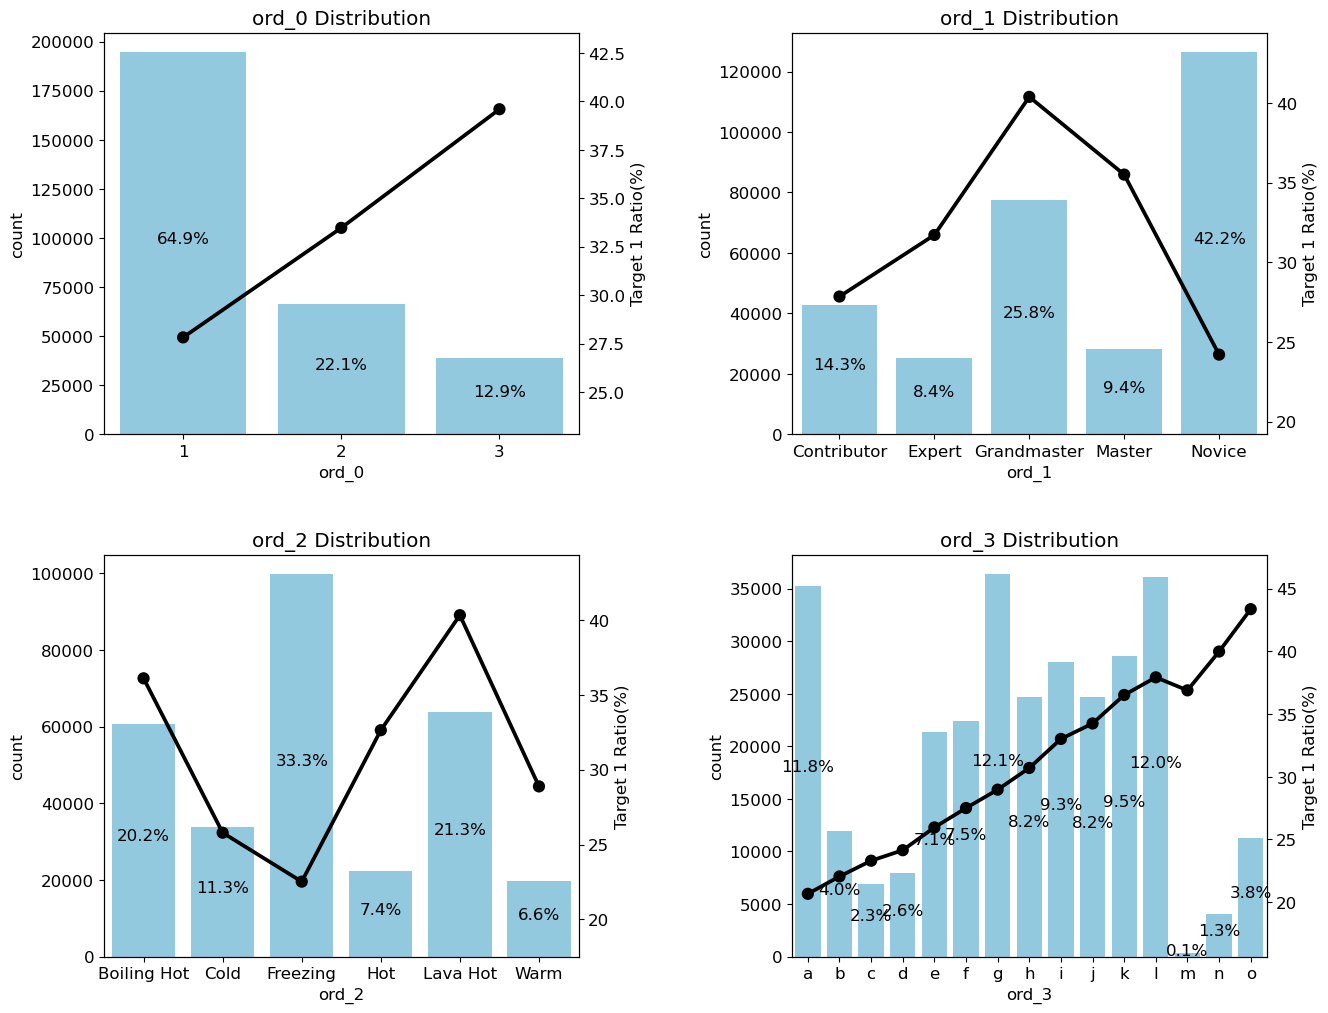

In [23]:
# 순서형 피처 분포
ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3']
plot_cat_dist_true_ratio(train, ord_features, num_rows=2, num_cols=2, size=(15,12))

In [24]:
from pandas.api.types import CategoricalDtype

# ord_1, ord_2 정렬
ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Bolling Hot', 'Lava Hot']

ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)

train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   bin_0   300000 non-null  int64   
 1   bin_1   300000 non-null  int64   
 2   bin_2   300000 non-null  int64   
 3   bin_3   300000 non-null  object  
 4   bin_4   300000 non-null  object  
 5   nom_0   300000 non-null  object  
 6   nom_1   300000 non-null  object  
 7   nom_2   300000 non-null  object  
 8   nom_3   300000 non-null  object  
 9   nom_4   300000 non-null  object  
 10  nom_5   300000 non-null  object  
 11  nom_6   300000 non-null  object  
 12  nom_7   300000 non-null  object  
 13  nom_8   300000 non-null  object  
 14  nom_9   300000 non-null  object  
 15  ord_0   300000 non-null  int64   
 16  ord_1   300000 non-null  category
 17  ord_2   239373 non-null  category
 18  ord_3   300000 non-null  object  
 19  ord_4   300000 non-null  object  
 20  ord_5   300000 non-null  object

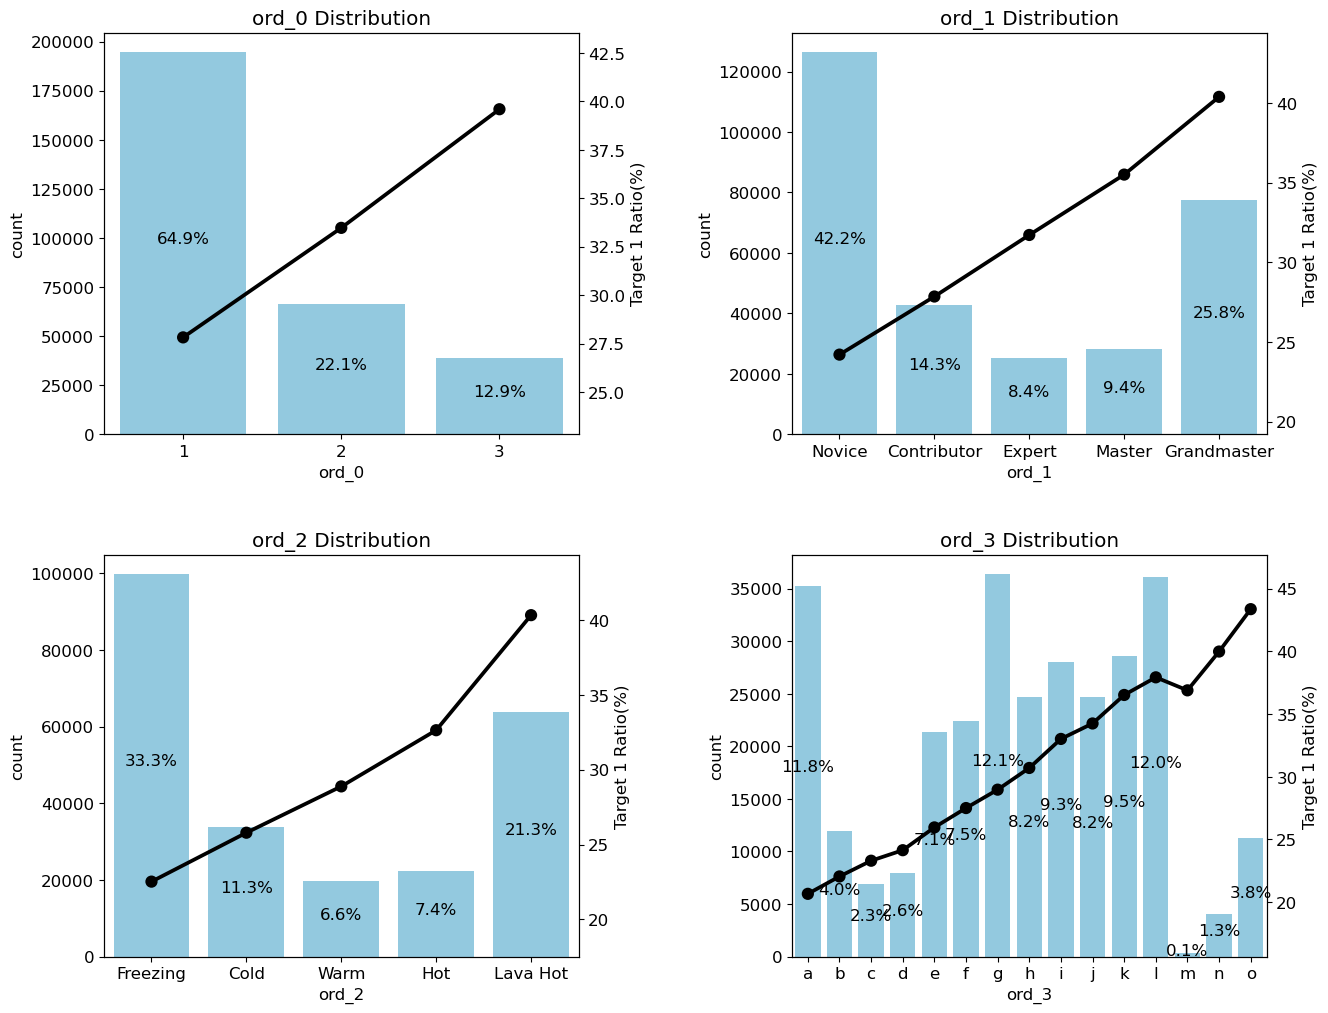

In [25]:
plot_cat_dist_true_ratio(train, ord_features, num_rows=2, num_cols=2, size=(15,12))

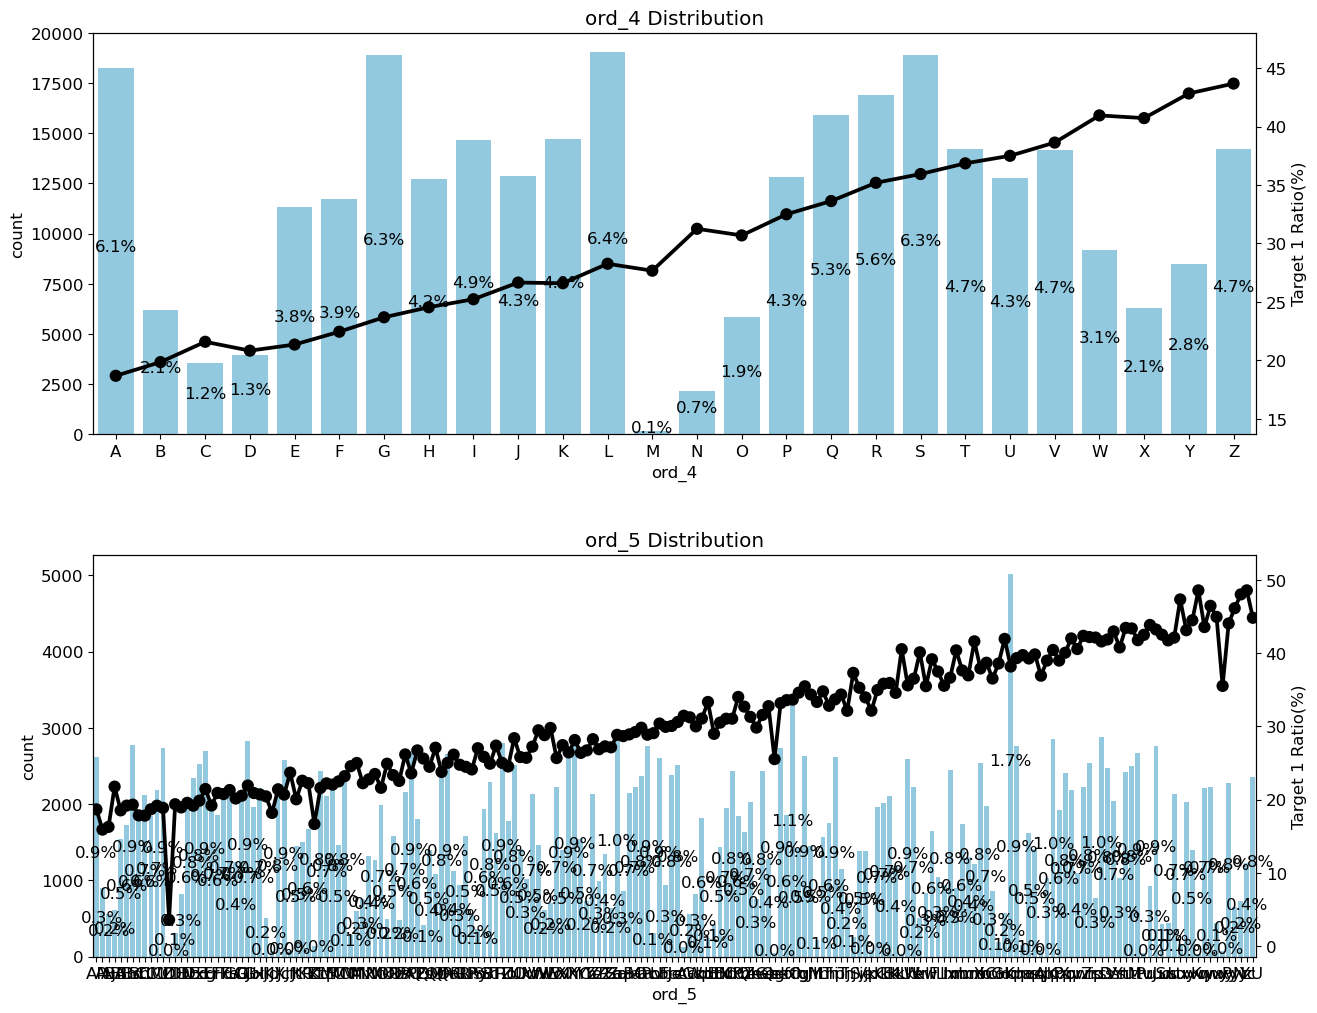

In [26]:
# ord_4, ord_5 분포
plot_cat_dist_true_ratio(train, ['ord_4', 'ord_5'], num_rows=2, num_cols=1, size=(15,12))

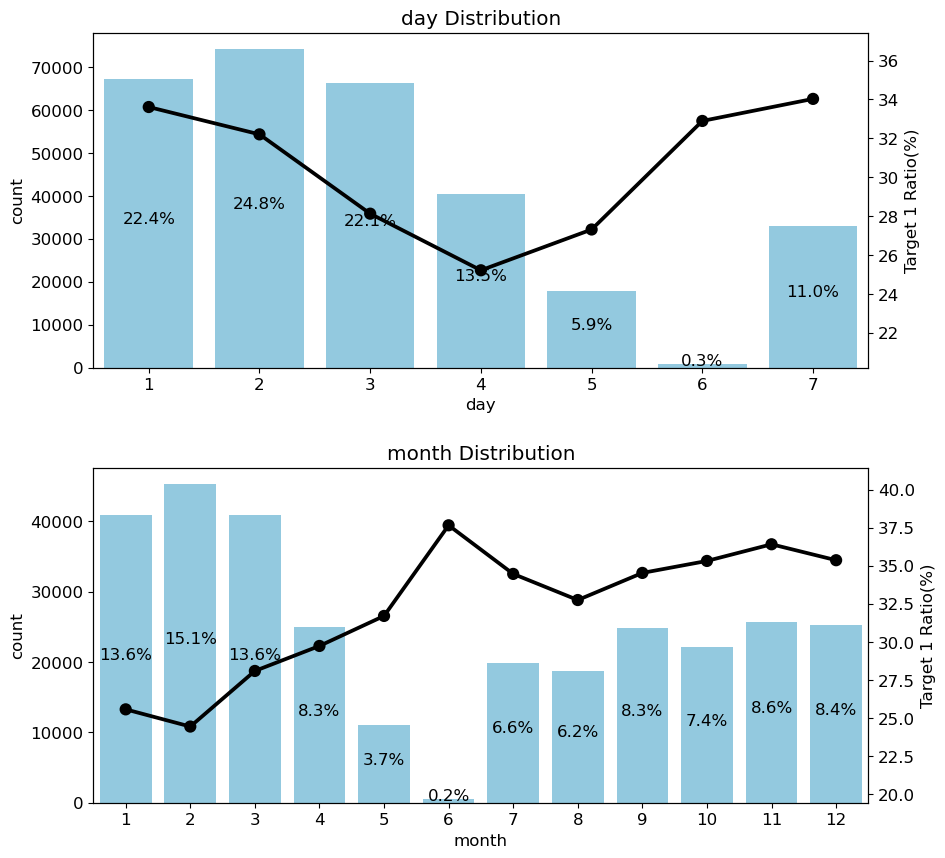

In [27]:
# 날짜 피처 분포
date_features = ['day', 'month']
plot_cat_dist_true_ratio(train, date_features, num_rows=2, num_cols=1, size=(10,10))

* 순환형 데이터
    * 순환하여 반복되는 데이터
    * ex> 계절, 월, 요일, 시간 등
    * 원핫 인코딩, [삼각함수(sin, cos) 인코딩](https://today-1.tistory.com/55)
    * 현 데이터에서는 원핫 인코딩의 결과가 좋았음
* 분석 정리
    * 결측값은 없음
    * 모든 피처가 중요하여 제거할 피처를 찾지 못함
    * 이진 피처 인코딩
        * 값이 숫자가 이닌 이진 피처는 0과 1로 인코딩
    * 명목형 피처 인코딩
        * 전체 데이터가 크지 않으므로 모두 원핫 인코딩
    * 순서형 피처 인코딩
        * 고유값들의 순서에 맞게 인코딩
    * 날짜 피처 인코딩
        * 원핫 인코딩
* 모델링 전략
    * 베이스라인 모델 : 로지스틱 회귀 모델
        * 피처 엔지니어링 : 모든 피처를 원핫 인코딩
    * 성능 개선 : 추가 피처 엔지니어링과 하이퍼파라미터 최적화
        * 피처 엔지니어링 : 피처 맞춤 인코딩과 피처 스케일링
        * 하이퍼파라미터 최적화 : 그리드 서치
        * 추가 팁 : 검증 데이터를 훈련에 이용